# Type T: townhouse; dev site - development site

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

C:\Users\tomde\AppData\Local\Temp\ipykernel_6216\3364595668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df1 = pd.read_csv('ttype.csv')
df1.head()

,Suburb,Rooms,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,PricePerSqFt
0,Airport West,3,t,840000,13.5,3,2,1.0,303,225.0,2016,-37.7180,144.8780,2772.277228
1,Airport West,3,t,700000,13.5,3,2,2.0,239,134.0,2009,-37.7218,144.8837,2928.870293
2,Airport West,2,t,450000,13.5,2,1,1.0,110,90.0,2015,-37.7216,144.8710,4090.909091
3,Airport West,3,t,700000,13.5,3,2,2.0,165,133.0,2009,-37.7270,144.8870,4242.424242
4,Airport West,3,t,540000,13.5,2,2,1.0,161,101.0,2010,-37.7231,144.8802,3354.037267


## Data cleaning
### Building area to Land size ratio

In [3]:
df1.shape

(972, 14)

#### Building area cannot be smaller than 0, so that would need to be removed

In [4]:
df1 = df1[df1['BuildingArea'] <= df1['Landsize']]
df1.shape

(800, 14)

#### Remove building area smaller than 1/4 of land size in python

In [5]:
df2 = df1[df1['BuildingArea'] >= df1['Landsize'] / 4]
df2.shape

(703, 14)

### Remove using std and mean for PricePerSqFT

In [6]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Suburb'):
        m = np.mean(subdf.PricePerSqFt)
        st = np.std(subdf.PricePerSqFt)
        reduced_df = subdf[(subdf.PricePerSqFt>(m-st)) & (subdf.PricePerSqFt<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [7]:
df2 = remove_pps_outliers(df2)
df2.shape

(421, 14)

### Remove features that is 3z away

In [8]:
column = ['Landsize','BuildingArea']

for col in column:
    df2['zscore'] = (df2[col] - df2[col].mean()) / df2[col].std()
    df2 = df2[(df2['zscore'] > -3) & (df2['zscore'] < 3)]
    
df3 = df2.drop('zscore', axis=1)

In [9]:
df3.shape

(414, 14)

In [10]:
df3 = df3.drop(['Rooms'], axis='columns')

In [11]:
df3.head()

,Suburb,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,PricePerSqFt
0,Aberfeldie,t,935000,9.1,3,2,2.0,217,149.0,2005,-37.75910,144.89230,4308.755760
2,Airport West,t,700000,13.5,3,2,2.0,239,134.0,2009,-37.72180,144.88370,2928.870293
3,Airport West,t,540000,13.5,2,2,1.0,161,101.0,2010,-37.72310,144.88020,3354.037267
4,Airport West,t,730000,10.4,3,1,2.0,242,124.0,2010,-37.72893,144.88859,3016.528926
5,Airport West,t,856000,10.4,3,2,1.0,300,212.0,2011,-37.71917,144.87819,2853.333333


### Encode

In [12]:
dummies = pd.get_dummies(df3.Suburb)
dummies.head(3)

,Aberfeldie,Airport West,Altona,Altona North,Armadale,Ascot Vale,Ashburton,Ashwood,Avondale Heights,Balwyn,...,Sunshine West,Surrey Hills,Templestowe Lower,Thornbury,Toorak,Vermont,Williamstown,Williamstown North,Yarraville,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
df4 = pd.concat([df3,dummies.drop('other',axis='columns')],axis='columns')
df4.head(3)

,Suburb,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,Sunshine,Sunshine West,Surrey Hills,Templestowe Lower,Thornbury,Toorak,Vermont,Williamstown,Williamstown North,Yarraville
0,Aberfeldie,t,935000,9.1,3,2,2.0,217,149.0,2005,...,False,False,False,False,False,False,False,False,False,False
2,Airport West,t,700000,13.5,3,2,2.0,239,134.0,2009,...,False,False,False,False,False,False,False,False,False,False
3,Airport West,t,540000,13.5,2,2,1.0,161,101.0,2010,...,False,False,False,False,False,False,False,False,False,False


### Remove properties within the same location where example the price of 3 bedroom is smaller than the price of 2 bedroom. 

In [14]:
df4.head(2)

,Suburb,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,Sunshine,Sunshine West,Surrey Hills,Templestowe Lower,Thornbury,Toorak,Vermont,Williamstown,Williamstown North,Yarraville
0,Aberfeldie,t,935000,9.1,3,2,2.0,217,149.0,2005,...,False,False,False,False,False,False,False,False,False,False
2,Airport West,t,700000,13.5,3,2,2.0,239,134.0,2009,...,False,False,False,False,False,False,False,False,False,False


In [15]:
df4.Suburb.value_counts()

Suburb
Bentleigh East    29
Pascoe Vale       16
Reservoir         14
Bentleigh         13
Maidstone         12
                  ..
Hawthorn           1
Highett            1
Mordialloc         1
Northcote          1
Heathmont          1
Name: count, Length: 107, dtype: int64

In [16]:
def plot_scatter_chart(df,Suburb):
    bhk2 = df[(df.Suburb==Suburb) & (df.Bedroom2==2)]
    bhk3 = df[(df.Suburb==Suburb) & (df.Bedroom2==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.Landsize,bhk2.Price,color='blue',label='2 bedroom', s=50)
    plt.scatter(bhk3.Landsize,bhk3.Price,marker='+', color='green',label='3 bedroom', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(Suburb)
    plt.legend()

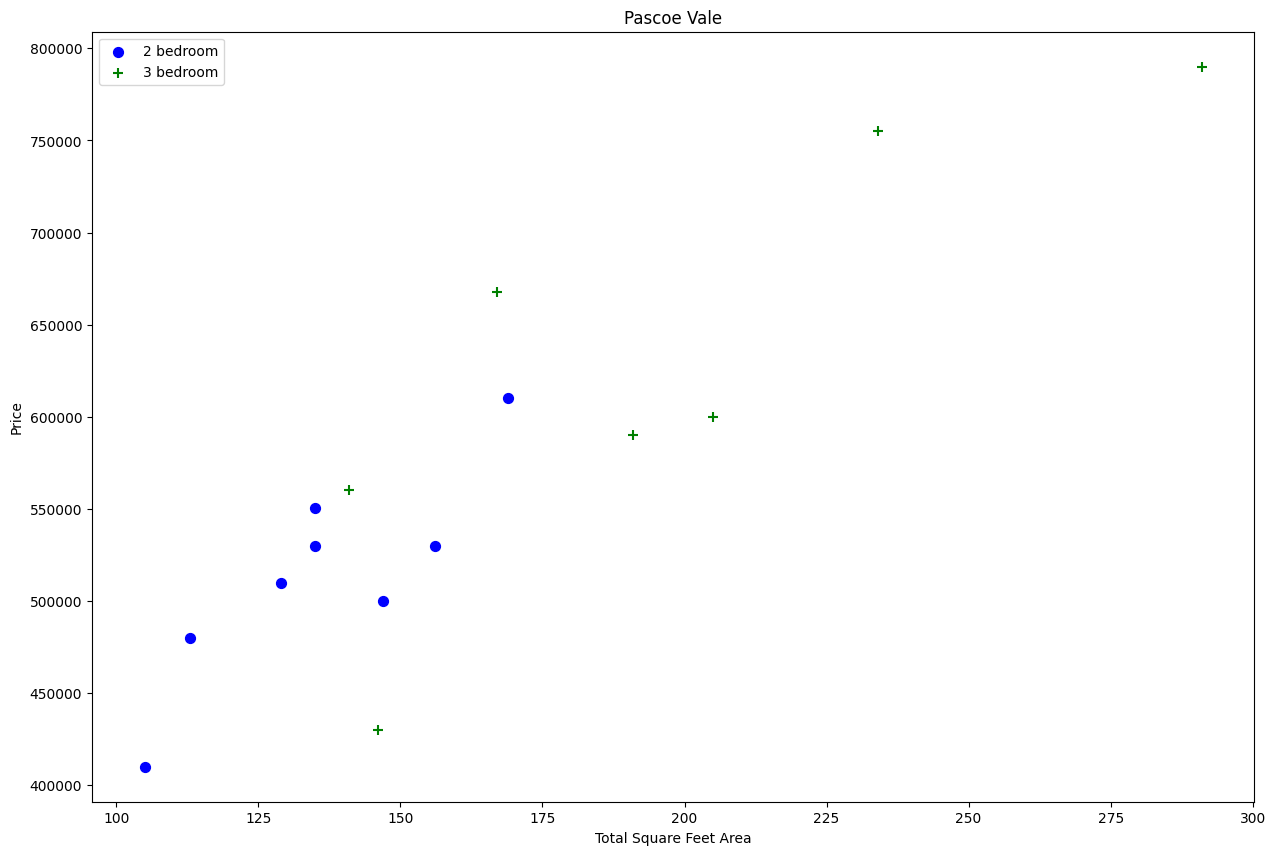

In [17]:
plot_scatter_chart(df4,"Pascoe Vale")

In [18]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('Suburb'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('Bedroom2'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.PricePerSqFt),
                'std': np.std(bhk_df.PricePerSqFt),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('Bedroom2'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.PricePerSqFt<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [19]:
df5 = remove_bhk_outliers(df4)
df5.shape

(400, 119)

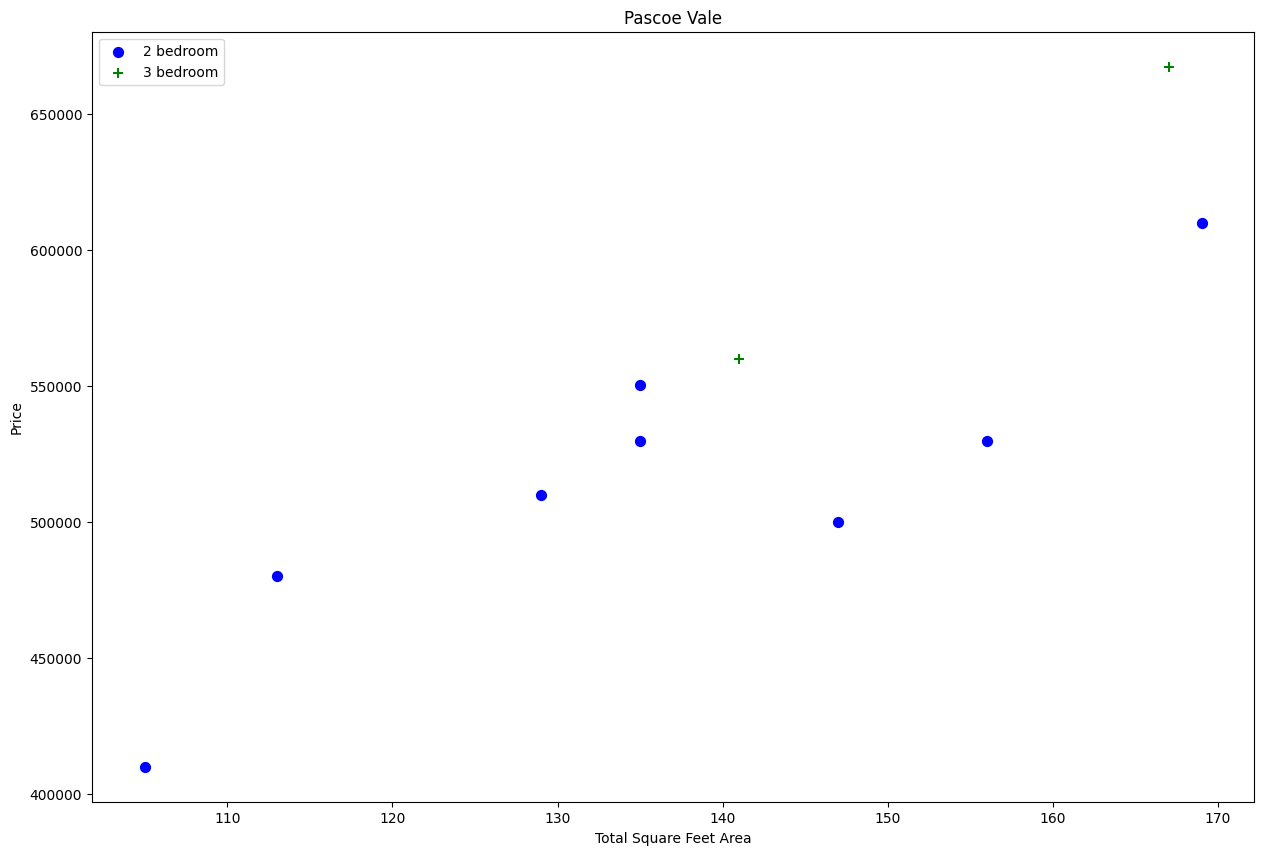

In [20]:
plot_scatter_chart(df5,"Pascoe Vale")

In [21]:
df5.head()

,Suburb,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,Sunshine,Sunshine West,Surrey Hills,Templestowe Lower,Thornbury,Toorak,Vermont,Williamstown,Williamstown North,Yarraville
0,Aberfeldie,t,935000,9.1,3,2,2.0,217,149.0,2005,...,False,False,False,False,False,False,False,False,False,False
2,Airport West,t,700000,13.5,3,2,2.0,239,134.0,2009,...,False,False,False,False,False,False,False,False,False,False
3,Airport West,t,540000,13.5,2,2,1.0,161,101.0,2010,...,False,False,False,False,False,False,False,False,False,False
4,Airport West,t,730000,10.4,3,1,2.0,242,124.0,2010,...,False,False,False,False,False,False,False,False,False,False
5,Airport West,t,856000,10.4,3,2,1.0,300,212.0,2011,...,False,False,False,False,False,False,False,False,False,False


In [22]:
df5 = df5.drop(['Suburb', 'PricePerSqFt'], axis='columns')
df5.head(3)

,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,Sunshine,Sunshine West,Surrey Hills,Templestowe Lower,Thornbury,Toorak,Vermont,Williamstown,Williamstown North,Yarraville
0,t,935000,9.1,3,2,2.0,217,149.0,2005,-37.7591,...,False,False,False,False,False,False,False,False,False,False
2,t,700000,13.5,3,2,2.0,239,134.0,2009,-37.7218,...,False,False,False,False,False,False,False,False,False,False
3,t,540000,13.5,2,2,1.0,161,101.0,2010,-37.7231,...,False,False,False,False,False,False,False,False,False,False


In [48]:
df5[(df5['Sunshine'] == 1) & (df5['Type'] == 't')]

,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,Sunshine,Sunshine West,Surrey Hills,Templestowe Lower,Thornbury,Toorak,Vermont,Williamstown,Williamstown North,Yarraville
388,t,500000,12.6,3,1,2.0,224,159.0,1985,-37.7863,...,True,False,False,False,False,False,False,False,False,False
389,t,410000,12.6,2,2,2.0,204,85.0,2008,-37.7982,...,True,False,False,False,False,False,False,False,False,False


# Concat csv

In [29]:
df_csv = pd.read_csv('final.csv')
df_concat = pd.concat([df5, df_csv])
df_concat.head()

,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,Wantirna,Wantirna South,Watsonia,Werribee,West Footscray,West Melbourne,Westmeadows,Wheelers Hill,Windsor,Yallambie
0,t,935000,9.1,3,2,2.0,217,149.0,2005,-37.75910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,t,700000,13.5,3,2,2.0,239,134.0,2009,-37.72180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,t,540000,13.5,2,2,1.0,161,101.0,2010,-37.72310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,t,730000,10.4,3,1,2.0,242,124.0,2010,-37.72893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,t,856000,10.4,3,2,1.0,300,212.0,2011,-37.71917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_concat.shape

(5055, 211)

In [49]:
df_concat[(df_concat['Sunshine'] == 1) & (df_concat['Type'] == 't')]

,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,Wantirna,Wantirna South,Watsonia,Werribee,West Footscray,West Melbourne,Westmeadows,Wheelers Hill,Windsor,Yallambie
388,t,500000,12.6,3,1,2.0,224,159.0,1985,-37.7863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,t,410000,12.6,2,2,2.0,204,85.0,2008,-37.7982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_concat = df_concat.fillna(False)

C:\Users\tomde\AppData\Local\Temp\ipykernel_6216\2807897723.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_concat = df_concat.fillna(False)


In [52]:
df_concat[(df_concat['Sunshine'] == 1) & (df_concat['Type'] == 't')]

,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,Wantirna,Wantirna South,Watsonia,Werribee,West Footscray,West Melbourne,Westmeadows,Wheelers Hill,Windsor,Yallambie
388,t,500000,12.6,3,1,2.0,224,159.0,1985,-37.7863,...,False,False,False,False,False,False,False,False,False,False
389,t,410000,12.6,2,2,2.0,204,85.0,2008,-37.7982,...,False,False,False,False,False,False,False,False,False,False


In [53]:
df_concat.to_csv('final.csv', index=False)